# Nowcasting confidence in job security using Google Trends
## 1. Dataset presentation
* Necessary libraries are imported below.
* Change provided Dates to Datetime objects to be able to utilize dates: F.e: Year-Month format is used for aggregation.
* Periodicity is set as monthly.

In [53]:
import pandas as pd 
import numpy as np 
import datetime
import helpers
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import statsmodels.formula.api as smf
from statsmodels.tsa.ar_model import AutoReg
from pytrends.request import TrendReq
FIGSIZE = (12, 6)

df = pd.read_csv('data/probability_dataset.csv', skiprows = 1).drop(columns = ['DK; NA', 'Unnamed: 11'])
df['Date'] = df.Year.apply(str) + "-" +  df.Month.apply(str)
df.Date = pd.to_datetime(df.Date)
df.set_index('Date', inplace = True)
df.index = pd.DatetimeIndex(df.index).to_period('M') # Set periodicity to monthly
df.drop(columns = ['Month', 'Year'], inplace = False) # Do not show month and year, but keep for aggregation

,0%,1-24%,25-49%,50%,51-74%,75-99%,100%,Mean
Date,,,,,,,,
2004-01,39,27,9,15,3,6,1,21.8
2004-02,42,28,8,11,3,5,2,20.2
2004-03,41,27,11,12,2,4,2,20.1
2004-04,37,29,10,13,3,5,2,21.9
2004-05,37,29,11,11,2,7,2,22.3
...,...,...,...,...,...,...,...,...
2020-06,41,27,12,11,2,4,3,20.7
2020-07,37,27,11,12,3,6,4,23.7
2020-08,38,30,11,10,2,5,3,21.4


Respondants were asked: 

"During the next 5 years, what do you think the chances are that you (or
your husband/wife) will lose a job that you wanted to keep ?". 

They were asked to answer an integer from 0 to 100. 

The dataset contains 8 columns. Columns 1 to 7 represent aggregates over certain percentage ranges. The last one is the overall average estimated probability the respondants gave. We will only look at the mean for now. 

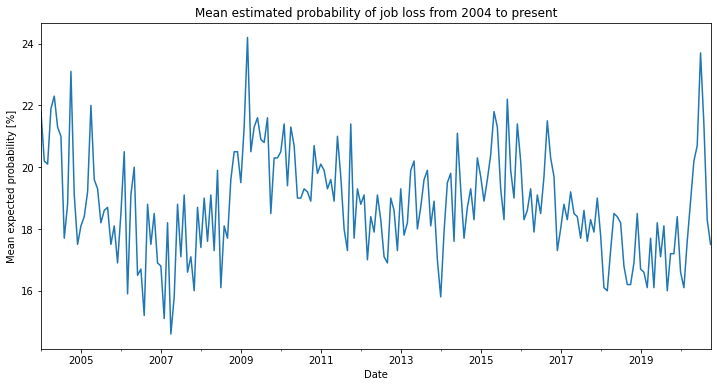

In [54]:
fig, ax = plt.subplots(1, 1, figsize = FIGSIZE) 
df['Mean'].plot()
ax.set_ylabel('Mean expected probability [%]')
ax.set_title('Mean estimated probability of job loss from 2004 to present')
plt.show()

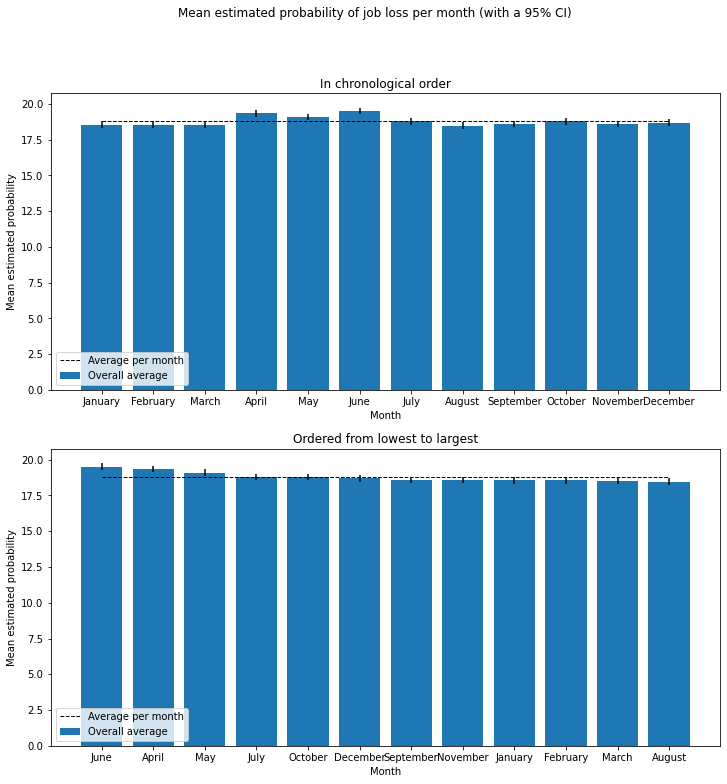

Estimated probability is typically above average in 
	April, May, June
and lower in 
	January, February, March, July, August, September, October, November, December.


In [55]:
months = [datetime.date(2000, m, 1).strftime('%B') for m in range(1, 13)]

monthly_df = df.set_index('Month')
y_error = np.zeros((2, 12))
for i in range(1, 13):
    l, h = helpers.bootstrap(monthly_df.Mean)
    m = np.mean(monthly_df.Mean)
    y_error[0,i-1] = m-l
    y_error[1,i-1] = h-m
    
    


fig, ax = plt.subplots(2, 1, figsize = (FIGSIZE[0], FIGSIZE[1]*2))

monthly_mean = df.groupby('Month').apply(np.mean)['Mean']
t = df.Mean.mean()

ax[0].bar(x = months, height = monthly_mean, yerr = y_error)
ax[0].plot([months[0], months[-1]], [t, t], "k--", linewidth = 1)
ax[0].set_xlabel('Month')
ax[0].set_ylabel('Mean estimated probability')
ax[0].set_title('In chronological order')
ax[0].legend(['Average per month', 'Overall average'])


sorted_order = np.argsort(-monthly_mean) # Sorted opposite to get descening order 
monthly_mean_sorted = np.array(monthly_mean)[sorted_order]
months_sorted = np.array(months)[sorted_order]


ax[1].bar(x = months_sorted, height = monthly_mean_sorted, yerr = y_error)
ax[1].plot([months_sorted[0], months_sorted[-1]], [t, t], "k--", linewidth = 1)
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Mean estimated probability')
ax[1].set_title('Ordered from lowest to largest')
ax[1].legend(['Average per month', 'Overall average'])

fig.suptitle("Mean estimated probability of job loss per month (with a 95% CI)")
plt.show()

above = np.array(months)[monthly_mean > t]
below = np.array(months)[monthly_mean <= t]
print('Estimated probability is typically above average in \n\t{}\nand lower in \n\t{}.'.format(', '.join(above), ', '.join(below)))

## 2. Baseline model 
We build a baseline auto-regressive model. This is appropriate, because the time series we are modeling can be assumed to depend linearly on previous terms and on a stochastic term. The most reasonable assumption is that values taken on the previous month and the previous year are the most relevant. The dependence on the previous month allows to explain low frequency evolutions (i.e. the probability at a given month depends on the value at the previous month, meaning doesn't change too sharply in general, just like the economic situation usually changes gradually). The dependency on the previous year is important to account for seasonal changes; we have shown above that the probability has a seasonality, on average peaking in April.

Let $y$ denote the mean estimated probability of job loss.
Then, we model: 
$y_t = \beta_0 + \beta_1 y_{t-1} + \beta_12 y_{t-12} + \epsilon_t \tag{1}$

Let's first see if this logical reasoning is correct by testing which lag terms are statistically significant. We want a familiywise Type I error rate of $\alpha$, and use the Šidák correction for the 13 tests (12 potential terms and intercept): 
$\alpha_{Šidák} = 1 - (1-\alpha)^{\frac{1}{13}} \approx 0.004 \tag{2}$
### 2.1 In-sample fit

In [56]:
def in_sample_fit(y, lag_terms, use_intercept = True, alpha = None):
    
    if use_intercept: 
        trend_reg = 'c'
    else:
        trend_reg= 'n'
        
    res = AutoReg(df.Mean, lags = lag_terms, trend = trend_reg).fit()
    
    # Create table of parameters
    summary = pd.DataFrame(data = {'Estimate': res.params,
                                      'Standard error': res.bse, 't value': res.tvalues, 
                                      'Pr(>|t|)': res.pvalues})
    rename_dict = {'intercept':'(Intercept)'}
    for k in lag_terms:
        rename_dict['Mean.L{}'.format(k)] = 'lag(y, -{})'.format(k)
        
    summary.rename(index = rename_dict, inplace = True)
    
    if alpha is not None:
        alpha_sidak = 1-(1-alpha)**(1/(len(lag_terms) + 1))
        new_col_name = 'At level {:.6f}'.format(alpha_sidak)
        summary[new_col_name] = summary['Pr(>|t|)'] < alpha_sidak
        summary[new_col_name].replace({True: 'Accepted', False: 'Rejected'}, inplace=True)
        
    return summary

lag_terms = np.arange(1, 13)
in_sample_all = in_sample_fit(df.Mean, lag_terms, use_intercept = True, alpha = 0.05)
in_sample_all

/Users/barissevilmis/miniconda3/envs/ada/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


,Estimate,Standard error,t value,Pr(>|t|),At level 0.003938
(Intercept),4.188594,1.648293,2.541171,0.011048,Rejected
"lag(y, -1)",0.343872,0.071557,4.805600,0.000002,Accepted
"lag(y, -2)",0.132966,0.075668,1.757237,0.078877,Rejected
"lag(y, -3)",0.025746,0.074747,0.344442,0.730514,Rejected
"lag(y, -4)",0.106899,0.076705,1.393629,0.163430,Rejected
"lag(y, -5)",-0.081326,0.076377,-1.064800,0.286966,Rejected
"lag(y, -6)",0.230605,0.076654,3.008371,0.002627,Accepted
"lag(y, -7)",0.008414,0.075987,0.110723,0.911836,Rejected
"lag(y, -8)",0.006398,0.075444,0.084809,0.932413,Rejected
"lag(y, -9)",0.070587,0.074967,0.941575,0.346410,Rejected


It turns out that the intercept and the value of from the previous year were not significant. But the value from 6 months ago is. We use these results to modify our model as: 
$y_t = \beta_1 y_{t-1} + \beta_6 y_{t-6} + \epsilon_t \tag{3}$

In [57]:
print("In sample with of the AR model:")
in_sample_all = in_sample_fit(df.Mean, [1, 6], use_intercept = False)
in_sample_all

In sample with of the AR model:


/Users/barissevilmis/miniconda3/envs/ada/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


,Estimate,Standard error,t value,Pr(>|t|)
"lag(y, -1)",0.561683,0.053631,10.473151,1.147587e-25
"lag(y, -6)",0.435345,0.053603,8.121725,4.596024e-16


Mean Absolute Error of the AR predictions: 1.1748


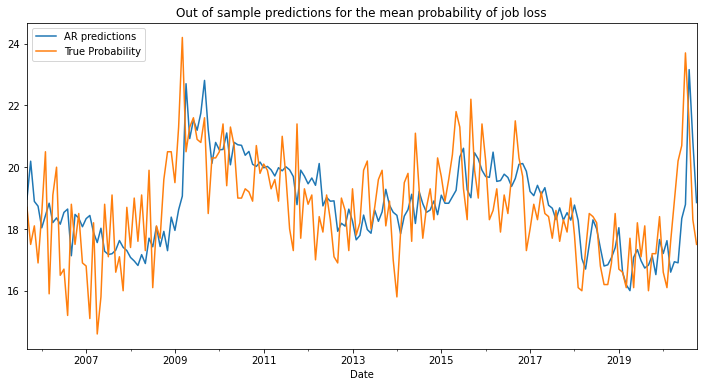

In [58]:
df['Mean_t_1'] = df.Mean.shift(1) 
df['Mean_t_6'] = df.Mean.shift(6)

k = 20 # How to choose k ? Fit gets better the larger k (>= 7) is
# k needs to be large for Trends ot be useful

forecast_start = df.index[k]
for i in range(k, len(df)):    
    mod_base = smf.ols(formula='Mean ~ Mean_t_1 + Mean_t_6', data=df[i-k:i])
    res_base = mod_base.fit()
    df.loc[df.index[i], 'Baseline'] = res_base.predict(df.iloc[i])[0]
    
fig, ax = plt.subplots(1, 1, figsize = FIGSIZE) 
ax.set_title('Out of sample predictions for the mean probability of job loss')
df.Baseline[forecast_start:].plot()
df.Mean[forecast_start:].plot()
ax.legend(['AR predictions', 'True Probability'])

print('Mean Absolute Error of the AR predictions: {:.4f}'.format(helpers.mae(df.Mean, df.Baseline, forecast_start)))

## 3. Using Google Trends
* In this section, we begin to utilize Google Trends features. 
* We try different methods to find different useful Google Trends features.
    * Manual features selection: Manually selected features are chosen. These features are selected by rational thinking(Possible correlations & causations) 
    * Spike and Slab: Features assigned with posterior probabilities, and ones with highest posterior values are chosen as possible features.
    * LassoCV:???

In [59]:
trends = pd.read_csv('data/trends.csv', index_col = 'Date')
trends.index = pd.DatetimeIndex(trends.index).to_period('M')

df_full = pd.merge(df, trends, left_index=True, right_index=True)
df_full.tail()

,Month,Year,0%,1-24%,25-49%,50%,51-74%,75-99%,100%,Mean,Mean_t_1,Mean_t_6,Baseline,Crisis
Date,,,,,,,,,,,,,,
2020-06,6,2020,41,27,12,11,2,4,3,20.7,20.2,18.4,18.336999,52
2020-07,7,2020,37,27,11,12,3,6,4,23.7,20.7,16.6,18.794005,36
2020-08,8,2020,38,30,11,10,2,5,3,21.4,23.7,16.1,23.159129,33
2020-09,9,2020,41,33,8,11,2,3,2,18.3,21.4,17.6,20.838315,39
2020-10,10,2020,47,27,8,10,3,3,2,17.5,18.3,18.9,18.854319,37


Mean Absolute Error of the predictions: 1.1668


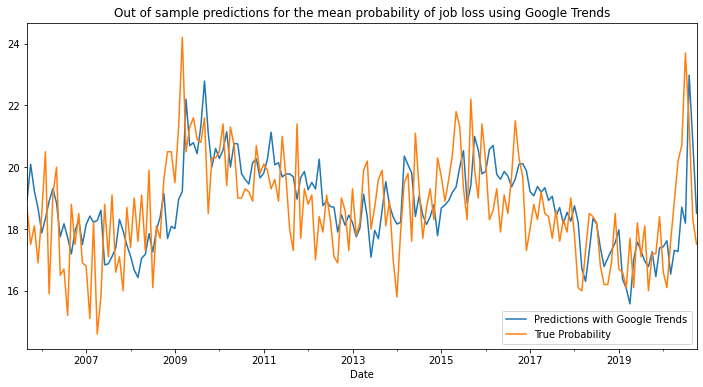

In [63]:
for i in range(k, len(df)):    
    mod_base = smf.ols(formula='Mean ~ Mean_t_1 + Mean_t_6 + Crisis', data=df_full[i-k:i])
    res_base = mod_base.fit()
    df_full.loc[df.index[i], 'Trends'] = res_base.predict(df_full.iloc[i])[0]
    
fig, ax = plt.subplots(1, 1, figsize = FIGSIZE) 
ax.set_title('Out of sample predictions for the mean probability of job loss using Google Trends')
df_full.Trends[forecast_start:].plot()
df_full.Mean[forecast_start:].plot()
ax.legend(['Predictions with Google Trends', 'True Probability'])

print('Mean Absolute Error of the predictions: {:.4f}'.format(helpers.mae(df_full.Mean, df_full.Trends, forecast_start)))

In [64]:
pytrend = TrendReq()
_geo = 'US' # Only in US
_gprop = '' # Default to web searches

# Build payload request to get data from Google trends
start, end = str(df.index[0].to_timestamp()).split(' ')[0], str(df.index[-1].to_timestamp()).split(' ')[0]
_timeframe = '{:s} {:s}'.format(start, end)
pytrend.build_payload(kw_list=['Job loss'],timeframe=_timeframe, geo=_geo,gprop=_gprop)

related_topic = pytrend.related_topics()


In [65]:
related_topic["Job loss"]["top"]["topic_title"].values

array(['Job', 'Weight loss', 'Employment', 'Retail loss prevention',
       'Insurance', 'Job description', 'Unemployment', 'Wage',
       'Mortgage loan', 'Depression', 'Salary', 'Management',
       'Rhinoplasty', 'Income', 'Rate', 'Human nose', 'Layoff',
       'Hair loss', 'Coronavirus disease 2019', 'Security',
       'Termination of employment', 'Barack Obama'], dtype=object)

In [69]:
kws=["Economy","Unemployment","Unemployment benefits","Unemployment insurance","Job","Crisis","Crime",
     "Home furnishings","Sport","Salary","Interest rate","Investment","Layoff","Recession","Home Financing",
     "Pension","Retirement","Bankruptcy","Profit","Stock market","Stock","Curriculum vitae", "Job Market",
     "Entrepreneurship","Risk"]

kws = list(set(list(related_topic["Job loss"]["top"]["topic_title"].values) + kws))

<AxesSubplot:title={'center':'Google Trends Monthly Data Points'}, xlabel='date'>

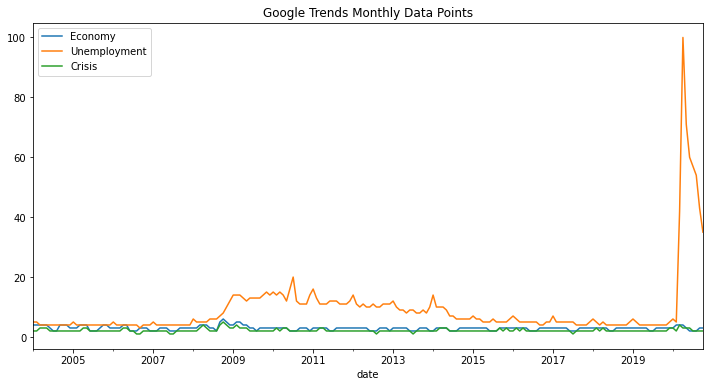

In [70]:
totalTrend = TrendReq(hl='en-US', tz=360)

# Keywords to search
kw_list = ["Economy", "Unemployment"]  
_cat = 0 # see https://github.com/pat310/google-trends-api/wiki/Google-Trends-Categories to choose categories

_geo = 'US' # Only in US
_gprop = '' # Default to web searches

# Build payload request to get data from Google trends
start, end = str(df.index[0].to_timestamp()).split(' ')[0], str(df.index[-1].to_timestamp()).split(' ')[0]
_timeframe = '{:s} {:s}'.format(start, end)

totalTrend.build_payload(kw_list, cat=_cat, timeframe=_timeframe, geo=_geo, gprop=_gprop)

# Get interest over time
# Capture Monthly Data for use in Normalization against Weekly
pytrends_df = totalTrend.interest_over_time()
pytrends_df.drop(columns ='isPartial', inplace = True)
pytrends_df.index = pd.DatetimeIndex(pytrends_df.index).to_period('M')

# Plot the Interest
pytrends_df.plot(title='Google Trends Monthly Data Points', figsize=FIGSIZE)

In [68]:
import gtab
t = gtab.GTAB()
t.set_options(pytrends_config={"geo": "US", "timeframe": "2004-01-01 2020-12-01"})
t.set_active_gtab("google_anchorbank_geo=US_timeframe=2004-01-01 2020-12-01.tsv")

Using directory '/Users/barissevilmis/miniconda3/envs/ada/lib/python3.8/site-packages/gtab'
Active anchorbank changed to: google_anchorbank_geo=_timeframe=2019-01-01 2020-08-01.tsv



FileNotFoundError: /Users/barissevilmis/miniconda3/envs/ada/lib/python3.8/site-packages/gtab/output/google_anchorbanks/google_anchorbank_geo=US_timeframe=2004-01-01 2020-12-01.tsv

In [61]:
kw_list = ["Economy", "Unemployment","Crisis","Loan","Pension"]  +['Job', 'Weight loss', 'Employment', 'Retail loss prevention',
       'Insurance', 'Job description', 'Wage',
       'Mortgage loan', 'Depression', 'Salary', 'Management',
       'Rhinoplasty', 'Income', 'Rate', 'Human nose', 'Layoff',
       'Hair loss', 'Coronavirus disease 2019', 'Security',
       'Termination of employment', 'Barack Obama']


# Make the queries which will return precise values!
queries  ={}
for kw in kw_list:
    query = t.new_query(kw)
    #query = query.groupby(pd.Grouper(freq='M')).agg("mean")
    #query.index = pd.DatetimeIndex(query.index).to_period('M')
    queries[kw] = query

Using /opt/anaconda3/lib/python3.8/site-packages/gtab/output/google_anchorbanks/google_anchorbank_geo=US_timeframe=2004-01-01 2020-12-01.tsv
New query 'Economy'
New query calibrated!
Using /opt/anaconda3/lib/python3.8/site-packages/gtab/output/google_anchorbanks/google_anchorbank_geo=US_timeframe=2004-01-01 2020-12-01.tsv
New query 'Unemployment'
New query calibrated!
Using /opt/anaconda3/lib/python3.8/site-packages/gtab/output/google_anchorbanks/google_anchorbank_geo=US_timeframe=2004-01-01 2020-12-01.tsv
New query 'Crisis'
New query calibrated!
Using /opt/anaconda3/lib/python3.8/site-packages/gtab/output/google_anchorbanks/google_anchorbank_geo=US_timeframe=2004-01-01 2020-12-01.tsv
New query 'Loan'
New query calibrated!
Using /opt/anaconda3/lib/python3.8/site-packages/gtab/output/google_anchorbanks/google_anchorbank_geo=US_timeframe=2004-01-01 2020-12-01.tsv
New query 'Pension'
New query calibrated!
Using /opt/anaconda3/lib/python3.8/site-packages/gtab/output/google_anchorbanks/goog

In [62]:
pytrends_df = pd.DataFrame(index=range(204),columns=["dummy"])
pytrends_df.index = queries["Economy"].index.to_period('M')

for kw in kw_list:
    query = queries[kw]
    kwn = kw.replace(" ","_")
    pytrends_df[kwn] = query["max_ratio"].values

pytrends_df = pytrends_df.drop(columns = ["dummy"])

In [63]:
df_full2 = pd.merge(df, pytrends_df, left_index=True, right_index=True)
df_full2.tail()

,Month,Year,0%,1-24%,25-49%,50%,51-74%,75-99%,100%,Mean,...,Rhinoplasty,Income,Rate,Human_nose,Layoff,Hair_loss,Coronavirus_disease_2019,Security,Termination_of_employment,Barack_Obama
2020-06,6,2020,41,27,12,11,2,4,3,20.7,...,2.057927,74.345389,190.211156,0.14,3.008665,8.624840,0.087719,162.261761,0.09,9.293174
2020-07,7,2020,37,27,11,12,3,6,4,23.7,...,2.134146,83.638562,211.949573,0.11,2.808087,9.025995,0.105263,164.720273,0.13,6.195449
2020-08,8,2020,38,30,11,10,2,5,3,21.4,...,1.905488,71.247664,198.363062,0.12,2.206354,9.427150,0.087719,162.261761,0.10,7.744311
2020-09,9,2020,41,33,8,11,2,3,2,18.3,...,1.981707,80.540838,203.797667,0.15,2.005777,9.427150,0.035088,167.178784,0.11,4.646587
2020-10,10,2020,47,27,8,10,3,3,2,17.5,...,2.134146,78.991976,211.949573,0.11,2.005777,9.627728,0.087719,172.095808,0.06,6.195449


## SPIKE AND SLAB ON PYTRENDS RELATED TOPICS

In [ ]:
df_full2n = df_full2.dropna()
try:
    df_full2n = df_full2n.drop(columns=["Baseline","Trends"])
except:
    print("Baseline and Trends already dropped!")


X = np.asanyarray(df_full2n.iloc[:,10:])
y = np.asanyarray(df_full2n.Mean)
def get_model(y, X):
    model = pm.Model()
    Sigma = .5 * np.matmul(X.T, X)
    Sigma += np.diag(np.diag(Sigma))
    Sigma = np.linalg.inv(Sigma)
    #Sigma = np.identity(43)
    #covMatrix = np.cov(X,bias=True)
    with model:
        xi = pm.Bernoulli('xi', .5, shape=X.shape[1]) #inclusion probability for each variable
        tau = pm.HalfCauchy('tau', 1)
        sigma = pm.HalfNormal('sigma', 10)
        
        beta = pm.MvNormal('beta', 0, tau*Sigma , shape=X.shape[1])
        #beta = pm.MvNormal('beta', 0, tau * Sigma, shape=X.shape[1]) #Prior for the non-zero coefficients
        mean = pm.math.dot(X, xi * beta) #Deterministic function to map the stochastics to the output
        y_obs = pm.Normal('y_obs', mean,sigma, observed=y) #Data likelihood
    return model

In [108]:
model1 = get_model(y, X)

In [109]:
X.shape

(182, 28)

In [112]:
with model1:
    trace = pm.sample(2000, random_seed = 4816, progressbar = True,tune=1000,chains=1)

ERROR (theano.gof.opt): SeqOptimizer apply <theano.tensor.opt.FusionOptimizer object at 0x7fb4acba0ee0>
ERROR (theano.gof.opt): Traceback:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/theano/scalar/basic.py", line 356, in filter
    raise TypeError(
TypeError: Value cannot accurately be converted to dtype (float64) and allow_downcast is not True

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/theano/gof/opt.py", line 249, in apply
    sub_prof = optimizer.optimize(fgraph)
  File "/opt/anaconda3/lib/python3.8/site-packages/theano/gof/opt.py", line 89, in optimize
    ret = self.apply(fgraph, *args, **kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/theano/tensor/opt.py", line 7774, in apply
    new_outputs = self.optimizer(node)
  File "/opt/anaconda3/lib/python3.8/site-packages/theano/tensor/opt.py", line 

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
Sampling 1 chain for 374 tune and 0 draw iterations (374 + 0 draws total) took 92 seconds.
No posterior samples. Unable to run convergence checks


In [100]:
results = pd.DataFrame({'var': df_full2n.columns[10:], 
                        'inclusion_probability':np.apply_along_axis(np.mean, 0, trace['xi'])
                       })
results.sort_values('inclusion_probability', ascending = False)

,var,inclusion_probability
0,Mean_t_1,1.0000
1,Mean_t_6,1.0000
4,Crisis,0.9995
5,Loan,0.9615
12,Job_description,0.1685
16,Salary,0.1175
23,Hair_loss,0.0730
9,Employment,0.0590
7,Job,0.0450
11,Insurance,0.0400


Mean Absolute Error of the predictions: 1.1704


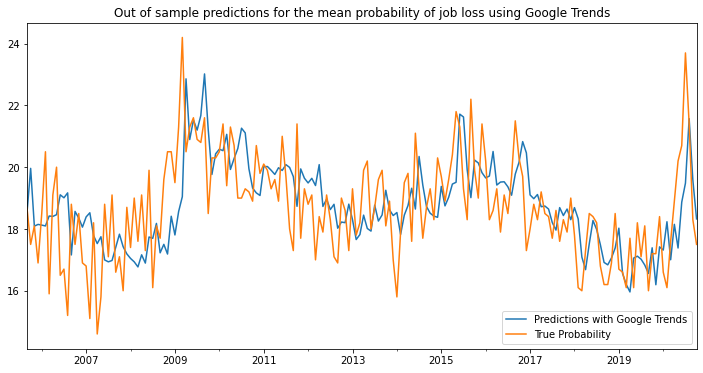

In [106]:
for i in range(k, len(df_full2)):    
    mod_base = smf.ols(formula='Mean ~ Mean_t_1 + Mean_t_6  + Loan', data=df_full2[i-k:i])
    res_base = mod_base.fit()
    df_full2.loc[df_full2.index[i], 'Trends'] = res_base.predict(df_full2.iloc[i])[0]
    
fig, ax = plt.subplots(1, 1, figsize = FIGSIZE) 
ax.set_title('Out of sample predictions for the mean probability of job loss using Google Trends')
df_full2.Trends[forecast_start:].plot()
df_full2.Mean[forecast_start:].plot()
ax.legend(['Predictions with Google Trends', 'True Probability'])

print('Mean Absolute Error of the predictions: {:.4f}'.format(helpers.mae(df_full2.Mean, df_full2.Trends, forecast_start)))


Mean Absolute Error of the predictions: 1.1049


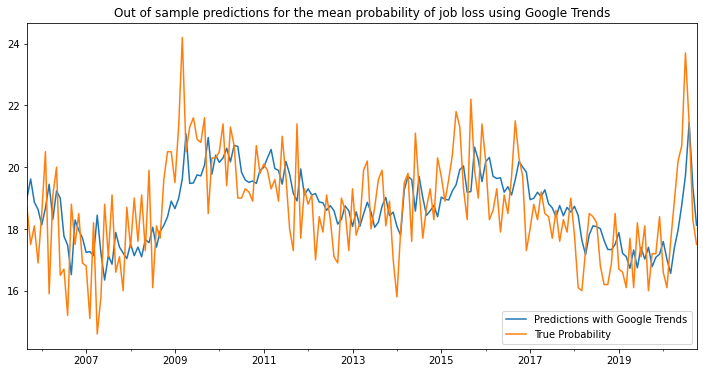

In [219]:
for i in range(k, len(df_full2)):    
    mod_base = smf.ols(formula='Mean ~ Mean_t_1 + Mean_t_6 + Loan + Crisis  ', data=df_full2[i-k:i])
    res_base = mod_base.fit_regularized(alpha=0.1)
    df_full2.loc[df_full2.index[i], 'Trends'] = res_base.predict(df_full2.iloc[i])[0]
    
fig, ax = plt.subplots(1, 1, figsize = FIGSIZE) 
ax.set_title('Out of sample predictions for the mean probability of job loss using Google Trends')
df_full2.Trends[forecast_start:].plot()
df_full2.Mean[forecast_start:].plot()
ax.legend(['Predictions with Google Trends', 'True Probability'])

print('Mean Absolute Error of the predictions: {:.4f}'.format(helpers.mae(df_full2.Mean, df_full2.Trends, forecast_start)))


In [223]:
mae_all_base = np.mean(np.abs(df_full2[k:]["Mean"]-df_full2[k:]["Baseline"]))
mae_all_trends = np.mean(np.abs(df_full2[k:]["Mean"]-df_full2[k:]["Trends"]))
improvement_all = (mae_all_trends - mae_all_base)/mae_all_base*-1

print("Base MAE all time","{:.3}".format(mae_all_base))
print("Trends MAE all time","{:.3}".format(mae_all_trends))
print("Improvement all time :","{:.2%}".format(improvement_all ))

Base MAE all time 1.17
Trends MAE all time 1.1
Improvement all time : 5.94%


<AxesSubplot:>

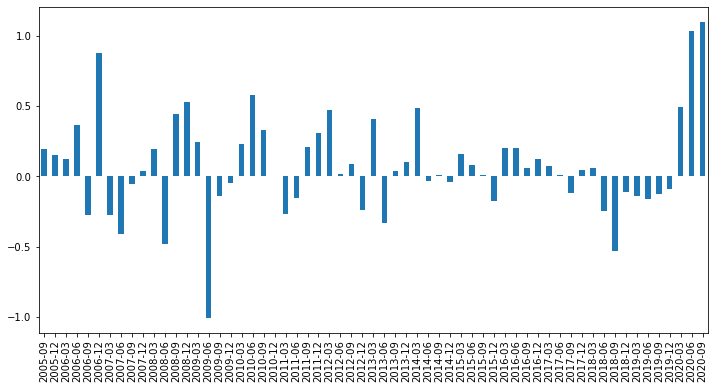

In [221]:
aeb = np.abs(df_full2[k:]["Mean"]-df_full2[k:]["Baseline"])
aet = np.abs(df_full2[k:]["Mean"]-df_full2[k:]["Trends"])
aef = aeb-aet
x = aef.groupby(pd.Grouper(freq='3M')).agg("mean")
x.plot.bar(figsize=FIGSIZE)

In [224]:
corona_start = -6
corone_end = 0
#Calculate MAE
recess_start = -7 # December 2007
recess_end = len(df_full2) #June 2009


mae_recess_base = np.mean(np.abs(df_full2[recess_start:recess_end]["Mean"]-df_full2[recess_start:recess_end]["Baseline"]))
mae_recess_trends = np.mean(np.abs(df_full2[recess_start:recess_end]["Mean"]-df_full2[recess_start:recess_end]["Trends"]))
improvement_recess = (mae_recess_trends - mae_recess_base)/mae_recess_base*-1



print("Base MAE during corona","{:.2}".format(mae_recess_base))
print("Trends MAE during corona","{:.2}".format(mae_recess_trends))
print("Improvement corona :","{:.2%}".format(improvement_recess ))


Base MAE during corona 2.6
Trends MAE during corona 1.6
Improvement corona : 37.38%
